<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/LinearModels_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and setup

In [335]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import scipy as sp
from scipy import stats

In [336]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load and proceses data

#### Load data from csv

In [337]:
path_after_2010 = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

#### Split into features and targets

In [338]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'SIG_SUB', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

X = violation_data[FEATURES]
y = violation_data[TARGETS]

#### Encode and scale features

In [339]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'SIG_SUB', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

Features shape: (1429135, 24)


#### Split data into training and testing datasets

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1071851, 24)
X_test shape: (357284, 24)
y_train shape: (1071851, 1)
y_train shape: (357284, 1)


## Define and Fit Simple Linear Regression Model

In [341]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [342]:
lin_reg_y_pred_train = lin_reg.predict(X_train)
lin_reg_y_pred_test = lin_reg.predict(X_test)

lin_reg_r_squared_train = r2_score(y_train, lin_reg_y_pred_train)
lin_reg_r_squared_test = r2_score(y_test, lin_reg_y_pred_test)

lin_reg_mae_train = mean_absolute_error(y_train, lin_reg_y_pred_train)
lin_reg_mae_test = mean_absolute_error(y_test, lin_reg_y_pred_test)

print('Simple Linear Regression Scores:')
print('Training R^2 = %.3f' % lin_reg_r_squared_train)
print('Training MAE = %.3f' % lin_reg_mae_train)

print('\nTesting R^2 = %.3f' % lin_reg_r_squared_test)
print('Testing MAE = %.3f' % lin_reg_mae_test)

Simple Linear Regression Scores:
Training R^2 = 0.276
Training MAE = 841.728

Testing R^2 = 0.260
Testing MAE = 837.038


## Define and Fit RANSAC Regressor

In [343]:
ransac_reg = RANSACRegressor().fit(X_train, y_train)

In [344]:
ransac_reg_y_pred_train = ransac_reg.predict(X_train)
ransac_reg_y_pred_test = ransac_reg.predict(X_test)

ransac_reg_r_squared_train = r2_score(y_train, ransac_reg_y_pred_train)
ransac_reg_r_squared_test = r2_score(y_test, ransac_reg_y_pred_test)

ransac_reg_mae_train = mean_absolute_error(y_train, ransac_reg_y_pred_train)
ransac_reg_mae_test = mean_absolute_error(y_test, ransac_reg_y_pred_test)

print('RANSAC Regression Scores:')
print('Training R^2 = %.3f' % ransac_reg_r_squared_train)
print('Training MAE = %.3f' % ransac_reg_mae_train)

print('\nTesting R^2 = %.3f' % ransac_reg_r_squared_test)
print('Testing MAE = %.3f' % ransac_reg_mae_test)

RANSAC Regression Scores:
Training R^2 = -0.011
Training MAE = 575.063

Testing R^2 = -0.012
Testing MAE = 565.638


# Removing Outliers in Target Data
Most of the data in the PROPOSED_PENALTY column seems to be less than 500. So, let's try removing large values from the dataset.

In [345]:
MAX_VALUE = 1000
violations_cliped = violation_data[violation_data['PROPOSED_PENALTY'] <= MAX_VALUE]

print('Total samples = %d' % len(violation_data))
print('Total samples with PROPOSED_PENALTY <= %d: %d' % (MAX_VALUE, len(violations_cliped)))

Total samples = 1429135
Total samples with PROPOSED_PENALTY <= 1000: 1259626


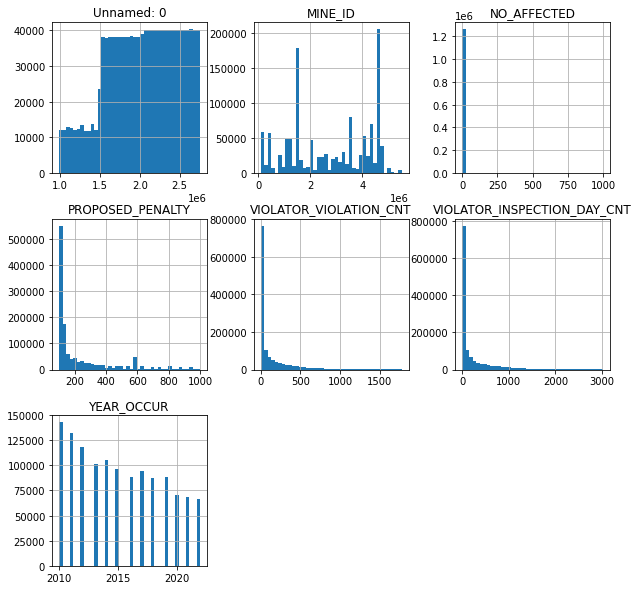

In [346]:
hist = violations_cliped.hist(figsize=(10,10), bins=40)

## Prepare Inlier Data

In [347]:
X_inliers = violations_cliped[FEATURES]
y_inliers = violations_cliped[TARGETS]

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns_inliers  = scaler.fit_transform(X_inliers[columns_to_scale])
encoded_columns_inliers = ohe.fit_transform(X_inliers[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre_inliers = np.concatenate([scaled_columns_inliers, encoded_columns_inliers], axis=1)
np.nan_to_num(X_pre_inliers, copy=False)

X_train_inliers, X_test_inliers, y_train_inliers, y_test_inliers = train_test_split(X_pre_inliers, y_inliers, test_size = 0.25, random_state = 0)

## Inlier Linear Regression

In [348]:
lin_reg_inliers = LinearRegression().fit(X_train_inliers, y_train_inliers)

In [349]:
lin_reg_inliers_y_pred_train = lin_reg_inliers.predict(X_train_inliers)
lin_reg_inliers_y_pred_test = lin_reg_inliers.predict(X_test_inliers)

lin_reg_inliers_r_squared_train = r2_score(y_train_inliers, lin_reg_inliers_y_pred_train)
lin_reg_inliers_r_squared_test = r2_score(y_test_inliers, lin_reg_inliers_y_pred_test)

lin_reg_inliers_mae_train = mean_absolute_error(y_train_inliers, lin_reg_inliers_y_pred_train)
lin_reg_inliers_mae_test = mean_absolute_error(y_test_inliers, lin_reg_inliers_y_pred_test)

print('Inlier Simple Linear Regression Scores:')
print('Training R^2 = %.3f' % lin_reg_inliers_r_squared_train)
print('Training MAE = %.3f' % lin_reg_inliers_mae_train)

print('\nTesting R^2 = %.3f' % lin_reg_inliers_r_squared_test)
print('Testing MAE = %.3f' % lin_reg_inliers_mae_test)

Inlier Simple Linear Regression Scores:
Training R^2 = 0.388
Training MAE = 105.540

Testing R^2 = 0.388
Testing MAE = 105.501


## Inlier RANSAC Regression

In [350]:
ransac_reg_inliers = RANSACRegressor(random_state=35).fit(X_train_inliers, y_train_inliers)

In [351]:
ransac_reg_inliers_y_pred_train = ransac_reg_inliers.predict(X_train_inliers)
ransac_reg_inliers_y_pred_test = ransac_reg_inliers.predict(X_test_inliers)

ransac_reg_inliers_r_squared_train = r2_score(y_train_inliers, ransac_reg_inliers_y_pred_train)
ransac_reg_inliers_r_squared_test = r2_score(y_test_inliers, ransac_reg_inliers_y_pred_test)

ransac_reg_inliers_mae_train = mean_absolute_error(y_train_inliers, ransac_reg_inliers_y_pred_train)
ransac_reg_inliers_mae_test = mean_absolute_error(y_test_inliers, ransac_reg_inliers_y_pred_test)

print('Inlier RANSAC Regression Scores:')
print('Training R^2 = %.3f' % ransac_reg_inliers_r_squared_train)
print('Training MAE = %.3f' % ransac_reg_inliers_mae_train)

print('\nTesting R^2 = %.3f' % ransac_reg_inliers_r_squared_test)
print('Testing MAE = %.3f' % ransac_reg_inliers_mae_test)

Inlier RANSAC Regression Scores:
Training R^2 = 0.090
Training MAE = 112.170

Testing R^2 = 0.102
Testing MAE = 111.643


# Focusing on Outliers
Now lets see if we can fit a model to the larger values.

In [352]:
violations_outliers = violation_data[violation_data['PROPOSED_PENALTY'] > MAX_VALUE]

print('Total samples = %d' % len(violation_data))
print('Total samples with PROPOSED_PENALTY > %d: %d' % (MAX_VALUE, len(violations_outliers)))

Total samples = 1429135
Total samples with PROPOSED_PENALTY > 1000: 169509


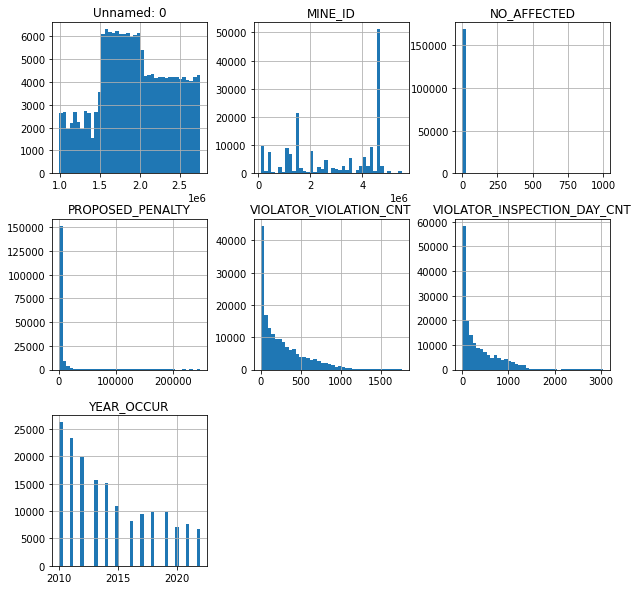

In [353]:
hist = violations_outliers.hist(figsize=(10,10), bins=40)

## Process outlier data

In [354]:
X_outliers = violations_outliers[FEATURES]
y_outliers = violations_outliers[TARGETS]

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns_outliers  = scaler.fit_transform(X_outliers[columns_to_scale])
encoded_columns_outliers = ohe.fit_transform(X_outliers[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre_outliers = np.concatenate([scaled_columns_outliers, encoded_columns_outliers], axis=1)
np.nan_to_num(X_pre_outliers, copy=False)

X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_pre_outliers, y_outliers, test_size = 0.25, random_state = 0)

## Outlier Linear Regression

In [355]:
lin_reg_outliers = LinearRegression().fit(X_train_outliers, y_train_outliers)

In [356]:
lin_reg_outliers_y_pred_train = lin_reg_outliers.predict(X_train_outliers)
lin_reg_outliers_y_pred_test = lin_reg_outliers.predict(X_test_outliers)

lin_reg_outliers_r_squared_train = r2_score(y_train_outliers, lin_reg_outliers_y_pred_train)
lin_reg_outliers_r_squared_test = r2_score(y_test_outliers, lin_reg_outliers_y_pred_test)

lin_reg_outliers_mae_train = mean_absolute_error(y_train_outliers, lin_reg_outliers_y_pred_train)
lin_reg_outliers_mae_test = mean_absolute_error(y_test_outliers, lin_reg_outliers_y_pred_test)

print('Outlier Simple Linear Regression Scores:')
print('Training R^2 = %.3f' % lin_reg_outliers_r_squared_train)
print('Training MAE = %.3f' % lin_reg_outliers_mae_train)

print('\nTesting R^2 = %.3f' % lin_reg_outliers_r_squared_test)
print('Testing MAE = %.3f' % lin_reg_outliers_mae_test)

Outlier Simple Linear Regression Scores:
Training R^2 = 0.275
Training MAE = 3416.393

Testing R^2 = 0.285
Testing MAE = 3416.473


## Outlier RANSAC Regression

In [357]:
ransac_reg_outliers = RANSACRegressor(random_state=2).fit(X_train_outliers, y_train_outliers)

In [358]:
ransac_reg_outliers_y_pred_train = ransac_reg_outliers.predict(X_train_outliers)
ransac_reg_outliers_y_pred_test = ransac_reg_outliers.predict(X_test_outliers)

ransac_reg_outliers_r_squared_train = r2_score(y_train_outliers, ransac_reg_outliers_y_pred_train)
ransac_reg_outliers_r_squared_test = r2_score(y_test_outliers, ransac_reg_outliers_y_pred_test)

ransac_reg_outliers_mae_train = mean_absolute_error(y_train_outliers, ransac_reg_outliers_y_pred_train)
ransac_reg_outliers_mae_test = mean_absolute_error(y_test_outliers, ransac_reg_outliers_y_pred_test)

print('Outlier RANSAC Regression Scores:')
print('Training R^2 = %.3f' % ransac_reg_outliers_r_squared_train)
print('Training MAE = %.3f' % ransac_reg_outliers_mae_train)

print('\nTesting R^2 = %.3f' % ransac_reg_outliers_r_squared_test)
print('Testing MAE = %.3f' % ransac_reg_outliers_mae_test)

Outlier RANSAC Regression Scores:
Training R^2 = 0.035
Training MAE = 3127.516

Testing R^2 = 0.025
Testing MAE = 3135.479
